In [32]:
import os 
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

from utilities.variational import VQE
from utilities.circuit_basics import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder

%load_ext autoreload
%autoreload 2


n_qubits = 4
qlr = 0.01
qepochs = 10**3
verbose=0
g=1
J=0
noise=0.0
problem="TFIM"


vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=qepochs, patience=100,
              random_perturbations=True, verbose=verbose, g=g, J = J, 
              problem=problem, noise_model=None)
indexed_circuit = [vqe_handler.n_qubits+k+vqe_handler.number_of_cnots for k in range(vqe_handler.n_qubits)]
circuit, symbols, idx = vqe_handler.give_circuit(indexed_circuit)
clean_energy = vqe_handler.give_energy(indexed_circuit,{s:0 for s in symbols})
circuit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(0, 0): ───Rx(th_0)───

(0, 1): ───Rx(th_1)───

(0, 2): ───Rx(th_2)───

(0, 3): ───Rx(th_3)───

In [34]:
ps=[]
for k in range(1,5)[::-1]:
    ps = np.append(ps, np.linspace(10**(-k), 10**(-k+1),10))

noisy_energy=[]
for p in tqdm(ps):

    vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=qepochs, patience=100,
                      random_perturbations=True, verbose=verbose, g=g, J = J, 
                      problem=problem, noise_model={ "channel":"depolarizing", "channel_params":[p], "q_batch_size":10**2})

    qbatch, symbols, index_to_symbols = vqe_handler.give_circuit_with_noise(indexed_circuit)
    qbatch_resolved=[]
    for k in qbatch:
        qbatch_resolved.append(cirq.resolve_parameters(k,{s:0 for s in symbols}))
    tfq_circuit = tfq.convert_to_tensor(qbatch_resolved)
    expectation = tfq.layers.Expectation()
    tfq_layer = expectation(tfq_circuit, operators=tfq.convert_to_tensor([vqe_handler.observable]*vqe_handler.q_batch_size))
    averaged_unitaries = tf.math.reduce_mean(tfq_layer, axis=0)
    energy = np.squeeze(tf.math.reduce_sum(averaged_unitaries, axis=-1))
    noisy_energy.append(energy)

100%|██████████| 40/40 [00:11<00:00,  3.38it/s]


In [ ]:
channel_p

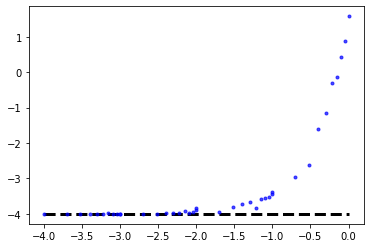

In [35]:
plt.plot(np.log10(ps),[clean_energy]*len(noisy_energy), '--', linewidth=3, color="black")
plt.plot(np.log10(ps),noisy_energy, '.', color="blue", alpha=0.7)